# Bayesian views on splines

Here, we do some Bayesian stuff with splines based on [Wood](https://www.crcpress.com/Generalized-Additive-Models-An-Introduction-with-R-Second-Edition/Wood/p/book/9781498728331), [Shalizi](https://www.stat.cmu.edu/~cshalizi/ADAfaEPoV/ADAfaEPoV.pdf), [Simonoff](https://www.springer.com/de/book/9780387947167)

In [35]:
library(greta)
library(gamair)
options(repr.plot.width=6, repr.plot.height=4)

In [36]:
data(engine)

## Piecewise linear splines

We start our stuff by doing linear stuff, in particular piecewise linear stuff.

In [3]:
tf.X <- function(x, xj)
{
    tf <- function(x, xj, k) 
    {
        dj <- xj * 0
        dj[j] <- 1
        approx(xj, dj, x)$y
    }
    nk <- length(xj)
    n <- length(x)
    X <- matrix(0, n, nk)
    for (j in seq(nk)) X[,j] <- tf(x, xj, j)
    X
}

In [4]:
size <- engine$size
wear <- engine$wear

In [5]:
sj <- seq(min(size), max(size), length=6)
X <- tf.X(size, sj)
b <- lm(wear ~ X - 1)

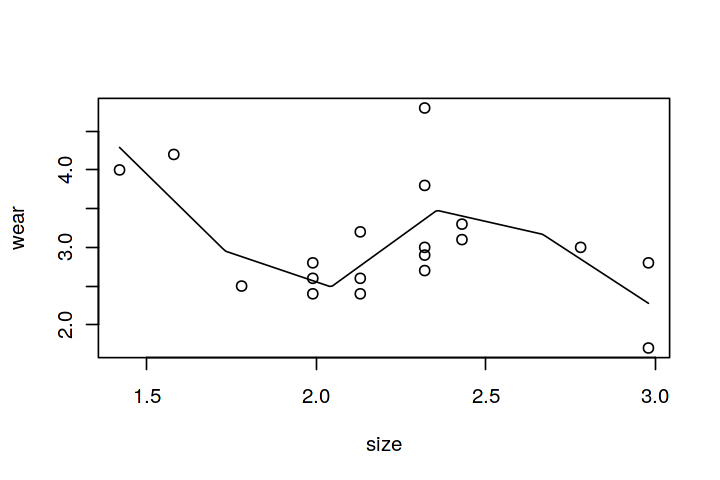

In [6]:
s <- seq(min(size), max(size), length=200)
Xp <- tf.X(s, sj)
plot(size, wear)
lines(s, Xp %*% coef(b))

In [7]:
beta <- greta::normal(0, 10, dim=6)
sd <- greta::uniform(0, 5)
wear <- as_data(wear)
distribution(wear) <- normal(X %*% beta, sd)

In [8]:
m <- model(beta, sd)

In [9]:
samples <- greta::mcmc(m)


running 4 chains simultaneously on up to 4 cores

    warmup ====================================== 1000/1000 | eta:  0s          
  sampling ====================================== 1000/1000 | eta:  0s          


In [10]:
posterior <- as.matrix(samples)[,-7]

In [11]:
head(posterior)

"beta[1,1]","beta[2,1]","beta[3,1]","beta[4,1]","beta[5,1]","beta[6,1]"
4.068438,2.633422,1.986840,3.893790,4.829701,0.7266498
2.726205,2.102246,3.000639,3.460995,1.290950,1.4887180
3.805030,1.529769,2.986883,2.845769,1.906473,2.5531373
3.966437,1.986252,3.179722,3.446920,2.578999,2.0653764
4.595534,1.406053,3.132922,2.947829,2.358329,2.1335670
4.595534,1.406053,3.132922,2.947829,2.358329,2.1335670


In [12]:
posterior_quants <- apply(as.matrix(samples), 2, quantile, c(.025, .5, .975))
posterior_quants

,"beta[1,1]","beta[2,1]","beta[3,1]","beta[4,1]","beta[5,1]","beta[6,1]",sd
2.5%,3.021102,1.445890,1.709882,2.857670,1.169392,1.278101,0.4617517
50%,4.284534,2.927248,2.498448,3.474472,3.135952,2.266536,0.6555546
97.5%,5.538995,4.322467,3.252579,4.117939,5.002405,3.258628,1.0281824


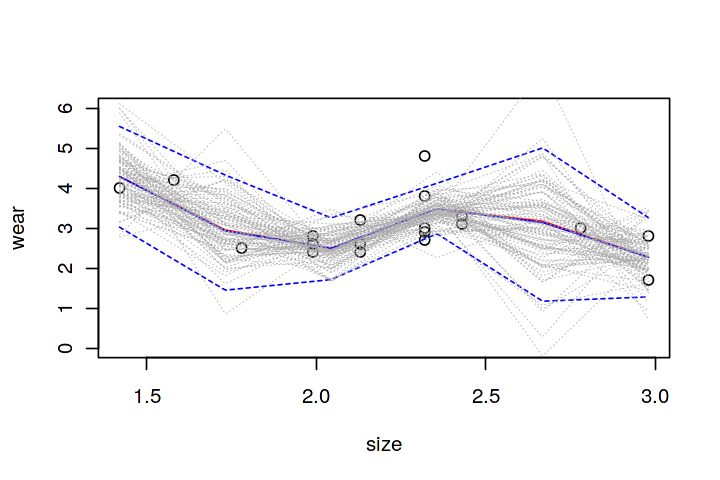

In [13]:
plot(size, wear, ylim=c(0, 6))
lines(s, Xp %*% coef(b), col="red")
lines(s, Xp %*% posterior_quants[1,1:6], col="blue", lty=2)
lines(s, Xp %*% posterior_quants[3,1:6], col="blue", lty=2)
lines(s, Xp %*% posterior_quants[2,1:6], col="blue", lty=1)
for (i in sample(nrow(posterior), 100)) {
    lines(s, Xp %*% posterior[i,], col="darkgrey", lty=3, lwd=.5)
}

### Smoothing

In [14]:
prs.fit <- function(y, x, xj, sp) 
{
    X <- tf.X(x, xj)
    D <- diff(diag(length(xj)))
    X <- rbind(X, sqrt(sp) * D)
    y <- c(y, rep(0, nrow(D)))
    lm(y ~ X - 1)
}

In [15]:
size <- engine$size
wear <- engine$wear
sj <- seq(min(size), max(size), length = 20)
b <- prs.fit(wear, size, sj, 10)

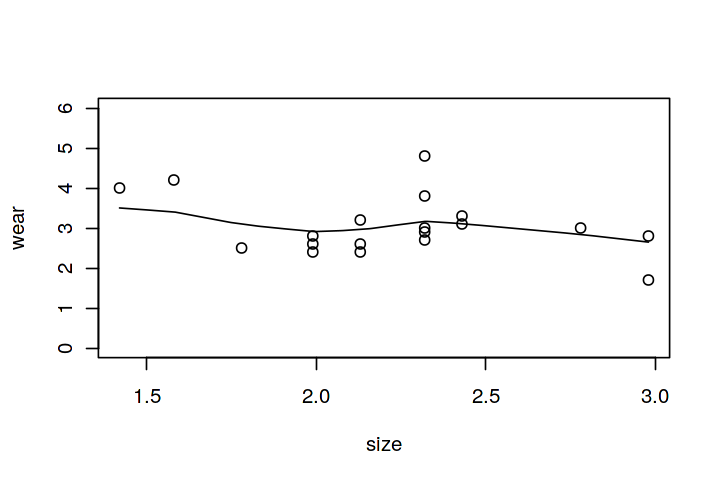

In [16]:
plot(size, wear, ylim=c(0, 6))
Xp <- tf.X(s, sj)
lines(s, Xp %*% coef(b))

In [28]:
rho <- seq(0, 11, length = 90)
n <- length(wear)
V <- rep(NA, 90)

In [29]:
par(mfrow=c(2, 1))

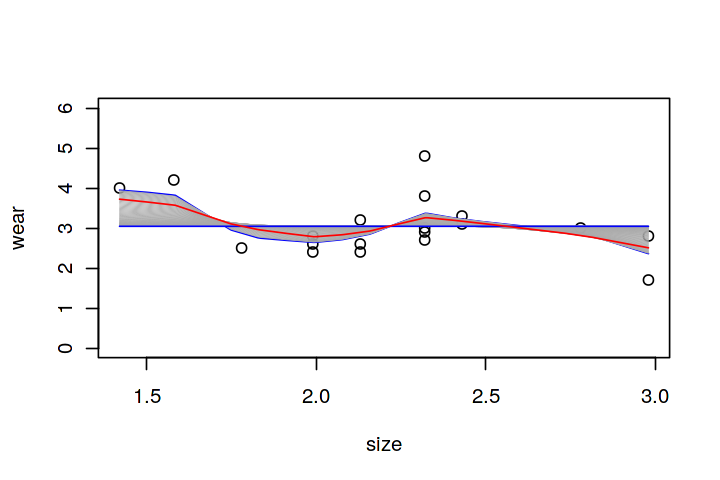

In [31]:
plot(size, wear, ylim=c(0, 6))
for (i in seq(90)) {
    b <- prs.fit(wear, size, sj, exp(rho[i]))
    trF  <- sum(influence(b)$hat[seq(n)])
    rss  <- sum((wear - fitted(b)[seq(n)])^2)
    V[i] <- n * rss  / (n - trF)^2 
    if (i == 1 || i == 90)
        lines(s, Xp %*% coef(b), col="blue", lty=1, lwd=1)
    else
        lines(s, Xp %*% coef(b), col="darkgrey", lty=1, lwd=.5)
}
sp <- exp(rho[V == min(V)])
b <- prs.fit(wear, size, sj, sp)
lines(s, Xp %*% coef(b), col="red", lty=1, lwd=1)

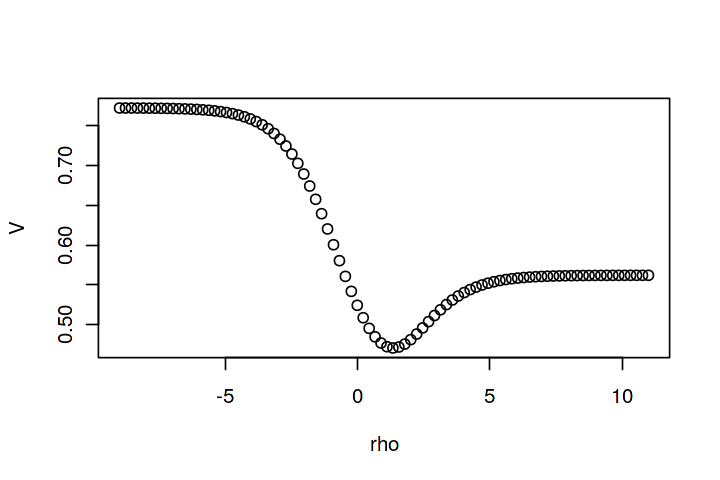

In [20]:
plot(rho, V)

In [21]:
library(lme4)

Loading required package: Matrix


In [22]:
llm

ERROR: Error in eval(expr, envir, enclos): object 'llm' not found


here make same with greta, make comparison to hierarchical mdoels and implement this